In [1]:
import numpy as np
import pandas as pd
import io
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
run_data = """
2023-01-21, 2.98
2023-01-23, 3.02
2023-01-24, 5.07
2023-01-26, 5.52
2023-01-26, 5.52
2023-01-27, 6.46
"""

In [3]:
distance = 42.0
target = np.ceil(distance * 0.8)

start_date = datetime(2023, 1, 21)
end_date = datetime(2023, 4, 30)
target_end_date = end_date - timedelta(days=7)

def next_day(date, day):
    days = (day - date.weekday() + 7) % 7
    return date + timedelta(days=days)

start_sunday = next_day(start_date, 6)

number_of_weeks = int((target_end_date - start_sunday).days / 7)

In [4]:
data = []

for i in range(0, number_of_weeks + 1):
    data.append(
        {
            "date": (start_sunday + timedelta(days = 7 * i)).strftime("%Y-%m-%d"),
            "distance": np.ceil(i * target / number_of_weeks),
            "type": "target"
        }
    )
    
df = pd.DataFrame(data)    

In [5]:
run_df = pd.read_csv(io.StringIO(run_data), names=["date", "distance"])
run_df["type"] = "individual run"

In [6]:
concat_df = pd.concat([df, run_df])

concat_df = concat_df.sort_values(["date"])

concat_df.reset_index(drop=True, inplace=True)

In [7]:
training_day_number = []
date_col = []
for i in range(0, concat_df.shape[0]):
    training_day_number.append((datetime.strptime(concat_df.loc[i, "date"], "%Y-%m-%d") - start_date).days)
    date_col.append(datetime.strptime(concat_df.loc[i, "date"], "%Y-%m-%d"))

concat_df["training_day_number"] = training_day_number
concat_df["datetime_date"] = date_col

In [8]:
concat_df[concat_df["type"] == "individual run"].groupby([pd.Grouper(key="datetime_date", freq='W'), "type"]).agg({"distance": ['sum', 'max']})

concat_df["weekly_total"] = concat_df[concat_df["type"] == "individual run"].groupby([pd.Grouper(key="datetime_date", freq='W'), "type"])["distance"].transform("sum")
concat_df["weekly_max"] = concat_df[concat_df["type"] == "individual run"].groupby([pd.Grouper(key="datetime_date", freq='W'), "type"])["distance"].transform("max")

max_sum_melt = concat_df.melt(id_vars=["training_day_number"], value_vars=["weekly_total", "weekly_max"])
max_sum_melt = max_sum_melt[~max_sum_melt["value"].isna()]
max_sum_melt = max_sum_melt.rename(columns={"value": "distance", "variable": "type"})

<ipython-input-9-d35627e46ead>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


[Text(-20.0, 0, '2023-01-21'),
 Text(0.0, 0, '2023-01-22'),
 Text(20.0, 0, '2023-01-23'),
 Text(40.0, 0, '2023-01-24'),
 Text(60.0, 0, '2023-01-26'),
 Text(80.0, 0, '2023-01-27'),
 Text(100.0, 0, '2023-01-29')]

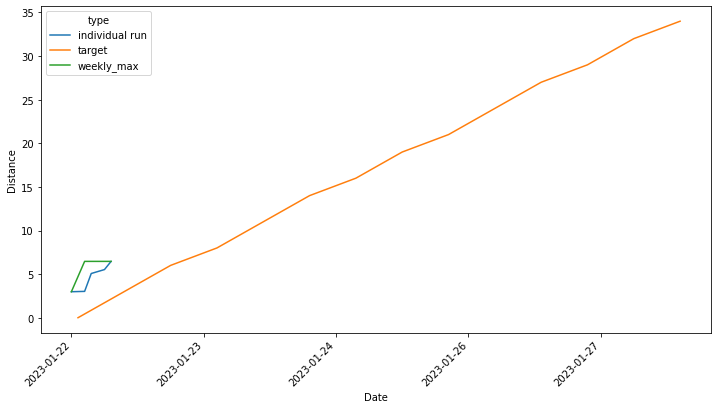

In [9]:
concat_df_02 = pd.concat([concat_df[["training_day_number", "distance", "type"]], max_sum_melt[["training_day_number", "distance", "type"]]])

concat_df_02 = concat_df_02[concat_df_02["type"] != "weekly_total"]

fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.lineplot(x='training_day_number', 
                   y='distance',
                   hue='type', 
                   data=concat_df_02)

x_dates = concat_df["date"].sort_values().unique()
ax.set(xlabel='Date', ylabel='Distance')
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')